# Homework 3 - Ames Housing Dataset

In [1]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer
from sklearn.model_selection import permutation_test_score
import math 
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import MinMaxScaler

In [2]:
import warnings
from scipy.spatial.distance import squareform
from scipy.spatial.distance import pdist
import plotly_express as px
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, r2_score
warnings.filterwarnings('ignore')
#To display atmost 1000 rows
pd.options.display.max_rows=1000

In [4]:
# *********** LOADING DATA FILES ******************
#importing train.csv file and test.csv files
train= pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
# train= pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
# test=pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')

#function to obtain the numeric columns of the data set and replace the NA values with the mean values
def num_data(df):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    numdf = df.select_dtypes(include=numerics)
    for column in numdf.columns:
        numdf[column].fillna(numdf[column].mean(), inplace=True)
        numdf[column]=numdf[column].astype(int)
    return numdf


In [33]:
#************cleaning the data*********************
#replacing numeric values in training and testing data with mean values
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numdf = train.select_dtypes(include=numerics)
for column in numdf.columns:
    train.fillna(train[column].mean(),inplace=True)

numdf1 = test.select_dtypes(include=numerics)
for column in numdf1.columns:
    test.fillna(test[column].mean(),inplace=True)

 ## Part 1 - Pairwise Correlations

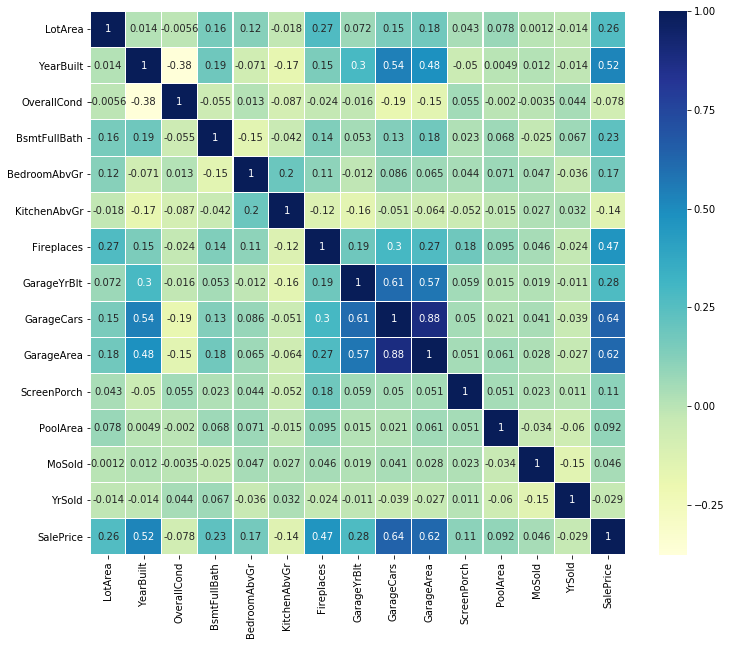

In [34]:
#select 15 columns from the given training dataset and create a new dataframe
df_select=num_data(train[['LotArea','YearBuilt','OverallCond', 'BsmtFullBath', 'BedroomAbvGr', 'KitchenAbvGr', 'Fireplaces',
       'GarageYrBlt','GarageCars', 'GarageArea', 'ScreenPorch', 'PoolArea', 'MoSold', 'YrSold', 'SalePrice']])
#obtain a pariwise pearson correlation between all the columns in the modified data frame
pearsoncorr = df_select.corr(method='pearson')
#plot a heatmap for the pearson correlation computed above
_, ax = plt.subplots(figsize =(12, 10)) 
sns.heatmap(pearsoncorr, ax = ax, cmap ="YlGnBu", linewidths = 0.1, annot= True) 


In [35]:
#obtain the most positive correlations
high = np.where(pearsoncorr>0.5)
high = [(pearsoncorr.index[x], pearsoncorr.columns[y]) for x, y in zip(*high)
                                        if x != y and x < y]
#print most positive correlations 
high

[('YearBuilt', 'GarageCars'),
 ('YearBuilt', 'SalePrice'),
 ('GarageYrBlt', 'GarageCars'),
 ('GarageYrBlt', 'GarageArea'),
 ('GarageCars', 'GarageArea'),
 ('GarageCars', 'SalePrice'),
 ('GarageArea', 'SalePrice')]

In [36]:
#obtain the most negative correlations
low = np.where(pearsoncorr<-0.35)
low = [(pearsoncorr.index[x], pearsoncorr.columns[y]) for x, y in zip(*low)
                                        if x != y and x < y]
#print most negative correlations
low

[('YearBuilt', 'OverallCond')]

Out of the correlations made, the most positive is between garagecars and garagearea(0.88).The most negative is between yearbuilt and overallcond(-0.38).

## Part 2 - Informative Plots

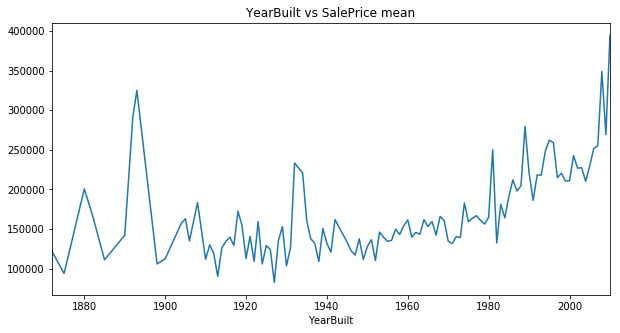

In [37]:
#line chart
train.groupby('YearBuilt')['SalePrice'].mean().plot(kind='line',title='YearBuilt vs SalePrice mean',figsize=(10,5))
plt.show()

This plot shows the mean of the Sale prices of the houses built in a particular year. Here, we can see
that
the Sale Price is not steadily increasing or decreasing from 1880- 2000. It's also noticeable that the mean
of the sale price of the houses built after 2000 is higher than others. Interesting thing to notice here is
that the mean sale price of the houses built between 1880-1900 also are quite high. This can be because of
few houses built in that period of time.

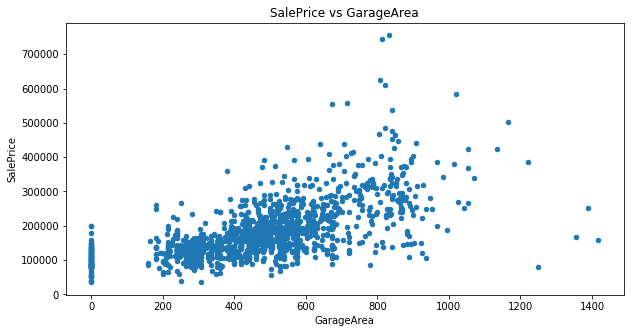

In [38]:
#scatter plot
train.plot.scatter(x ='GarageArea', y ='SalePrice',figsize=(10,5), title='SalePrice vs GarageArea') 
plt.show() 

No dependency is noticed between the sale price of the house and its garage area. There are houses with high garage 
area which were sold for a cheaper price and also most houses with garage area between 200 and 400 have a sale price
between 10000 and 20000

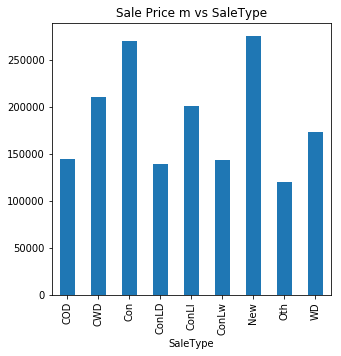

In [39]:
#bar graph
train.groupby('SaleType')['SalePrice'].mean().plot(kind='bar',title='Sale Price m vs SaleType',figsize=(5,5))
plt.show()

We can notice that New Homes which are just constructed have the highest sale price mean. Also houses sold on 
contracts with 15% down payment have the second highest mean. Contracts with low down payment have the second lowest sale price mean.

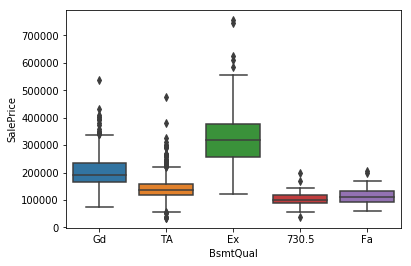

In [40]:
#boxplot
sns.boxplot(x='BsmtQual', y='SalePrice', data=train)

From the above plot, we can see that the basement quality is a very important parameter which would affect the sale price of the house. As we can see the houses with excellent quality have higher mean sale price than all the others. 

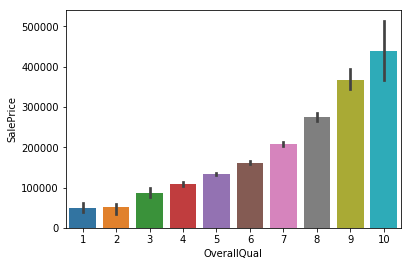

In [41]:
sns.barplot(train.OverallQual,train.SalePrice)

Overall material and finish of the house is an important paramter for determining the sale price. The houses are ranked from 10 to 1 based on their overall quality. Clearly, houses with rank 10 have the highest sale price mean and houses with ranks 2 and 1 almost have the same sale price mean.

## Part 3 - Handcrafted Scoring Function

In [42]:
#A scoring function based on the few qualities of the house. 
numdata=num_data(train)
numdata['Desirability']= (numdata['YearBuilt']*0.5)+(numdata['OverallQual']*0.25)+(numdata['FullBath']*0.2)+(numdata['1stFlrSF']*0.1)+(numdata['TotRmsAbvGrd']*0.3)
numdata.sort_values('Desirability').head(10)

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,Desirability
1100,1101,30,60,8400,2,5,1920,1950,0,290,...,0,0,0,0,0,0,1,2009,60000,1005.40
705,706,190,70,5600,4,5,1930,1950,0,0,...,0,0,0,0,0,3500,7,2010,55000,1005.70
533,534,20,50,5000,1,3,1946,1950,0,0,...,0,0,0,0,0,0,1,2007,39300,1007.45
968,969,50,50,5925,3,6,1910,1950,0,0,...,0,0,0,0,0,0,5,2009,37900,1017.75
29,30,30,60,6324,4,6,1927,1950,0,0,...,0,87,0,0,0,0,5,2008,68500,1017.90
1137,1138,50,54,6342,5,8,1875,1996,0,0,...,0,176,0,0,0,0,5,2010,94000,1018.75
61,62,75,60,7200,5,7,1920,1996,0,0,...,0,144,0,0,0,0,3,2007,101000,1021.35
155,156,50,60,9600,6,5,1924,1950,0,0,...,8,128,0,0,0,0,4,2008,79000,1022.40
125,126,190,60,6780,6,8,1935,1982,0,490,...,0,0,0,0,0,0,6,2006,84500,1022.70
329,330,70,60,6402,5,5,1920,1950,0,0,...,0,137,0,0,0,0,7,2009,78000,1022.85


The top ten desirable houses are:
         ID
1298    1299
496      497
523      524
1024    1025
1373    1374
440      441
1044    1045
691      692
898      899
224      225

Least desirable houses are:
        ID
1100    1101
705      706
533      534
968      969
29        30
1137    1138
61        62
155      156
125      126
329      330

I considered different columns based on their correlation with the Sale Price column. I continued to tweak this by alloting each column a different weight based on it's relation with the sale price. I inserted a new column called 'Desirability' into the dataset which will contain these values. Based on this, I sorted the dataframe based on the desirability values and obtained the top 10 desirable and least desirable houses.

## Part 4 - Pairwise Distance Function

In [43]:
#using euclidean distances and minmax scalar
euc_dist=pd.DataFrame(euclidean_distances(numdata))
euc_dist.head(5)

,0,1,2,3,4,5,6,7,8,9,...,1450,1451,1452,1453,1454,1455,1456,1457,1458,1459
0,0.000000,27052.126479,15263.957024,68512.881614,41913.177298,65751.050005,98527.102343,8774.953222,78642.828022,90513.627555,...,72537.472792,78635.562309,63706.483681,124336.757385,23602.798032,33554.276764,5466.600756,58088.338092,66425.919744,61052.072414
1,27052.126479,0.000000,42052.210419,41523.870425,68676.125756,38783.662944,125504.054787,18581.818657,51741.167642,63540.300078,...,45576.703430,105615.609270,37019.471546,97327.789909,4414.142841,7036.747886,28787.528285,85071.594696,39429.681569,34038.186158
2,15263.957024,42052.210419,0.000000,83518.747377,26679.103038,80558.015317,83524.977134,23539.015867,93743.891906,105577.644375,...,87554.988771,63663.078680,78888.382018,139150.008072,38728.494775,48642.316439,13817.106529,43164.315103,81421.231190,76039.985501
3,68512.881614,41523.870425,83518.747377,0.000000,110105.268760,5587.984338,167011.492455,60019.102471,10681.136230,22145.775585,...,4551.741864,147107.363082,7948.535463,56077.969407,45085.204970,35073.590696,70131.465228,126538.436340,3076.699142,7811.855010
4,41913.177298,68676.125756,26679.103038,110105.268760,0.000000,107010.549313,57175.275580,50158.973688,120380.927796,132189.008504,...,114145.221797,37500.337490,105557.363278,165549.492248,65386.471012,75291.382486,40071.070057,17569.118012,108001.586418,102616.051318


In [44]:
scaler = MinMaxScaler()
print(scaler.fit(euc_dist))
dist=pd.DataFrame(scaler.transform(euc_dist))
dist.head(5)

MinMaxScaler(copy=True, feature_range=(0, 1))


,0,1,2,3,4,5,6,7,8,9,...,1450,1451,1452,1453,1454,1455,1456,1457,1458,1459
0,0.000000,0.047159,0.028713,0.111379,0.082986,0.107426,0.219847,0.015807,0.125768,0.142055,...,0.117158,0.167993,0.104389,0.185430,0.041395,0.057835,0.010029,0.118868,0.108361,0.100476
1,0.049485,0.000000,0.079103,0.067504,0.135975,0.063366,0.280042,0.033473,0.082746,0.099722,...,0.073613,0.225632,0.060660,0.145150,0.007742,0.012129,0.052814,0.174085,0.064322,0.056018
2,0.027922,0.073308,0.000000,0.135774,0.052823,0.131618,0.186373,0.042403,0.149918,0.165697,...,0.141413,0.136006,0.129266,0.207522,0.067922,0.083841,0.025349,0.088329,0.132822,0.125143
3,0.125327,0.072387,0.157104,0.000000,0.218003,0.009130,0.372659,0.108119,0.017082,0.034756,...,0.007352,0.314272,0.013024,0.083632,0.079071,0.060453,0.128664,0.258940,0.005019,0.012856
4,0.076670,0.119720,0.050185,0.178995,0.000000,0.174836,0.127577,0.090356,0.192516,0.207462,...,0.184360,0.080114,0.172965,0.246893,0.114675,0.129774,0.073515,0.035952,0.176183,0.168880


In [45]:
subgroup = train.groupby(['SaleType', 'HouseStyle']).size().unstack().fillna(0)
distfun=pd.DataFrame(
    squareform(pdist(subgroup.loc[['WD', 'New', 'CWD','COD','ConLD','ConLI','ConLw','Oth','Con']])),
    columns = ['WD', 'New', 'CWD','COD','ConLD','ConLI','ConLw','Oth','Con'],
    index = ['WD', 'New', 'CWD','COD','ConLD','ConLI','ConLw','Oth','Con']
)
distfun

,WD,New,CWD,COD,ConLD,ConLI,ConLw,Oth,Con
WD,0.000000,653.252631,737.269964,710.012676,734.898632,736.004076,736.516123,736.426507,737.545253
New,653.252631,0.000000,86.625631,60.456596,84.658136,85.246701,85.772956,85.445889,86.614087
CWD,737.269964,86.625631,0.000000,29.715316,3.872983,1.732051,1.732051,2.645751,1.414214
COD,710.012676,60.456596,29.715316,0.000000,26.795522,28.635642,28.809721,28.178006,29.916551
ConLD,734.898632,84.658136,3.872983,26.795522,0.000000,3.741657,3.464102,3.464102,4.582576
ConLI,736.004076,85.246701,1.732051,28.635642,3.741657,0.000000,1.414214,2.449490,1.732051
ConLw,736.516123,85.772956,1.732051,28.809721,3.464102,1.414214,0.000000,2.000000,1.732051
Oth,736.426507,85.445889,2.645751,28.178006,3.464102,2.449490,2.000000,0.000000,2.236068
Con,737.545253,86.614087,1.414214,29.916551,4.582576,1.732051,1.732051,2.236068,0.000000


I used euclidean distance to see the similarity/dissimilarity between all the houses(pairwise). It is seen that the more the distance, the dissimilar are the two houses. I also used pdist to compare different housetypes and see their similarity. I also used minmaxscalar to obtain the distances between 0 and 1 to make the comparison simpler.

## Part 5 - Clustering

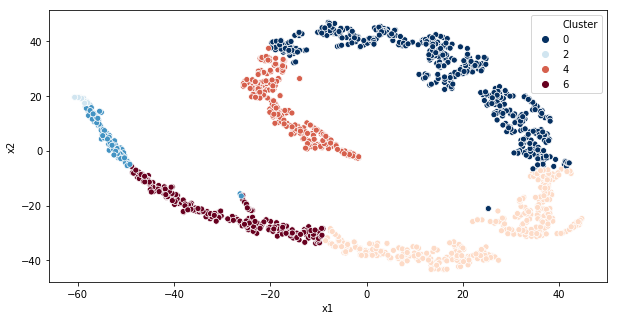

In [46]:
usemod = numdata
pca = PCA(n_components=30).fit(usemod)
evr=np.cumsum(pca.explained_variance_ratio_)
pca = PCA(n_components=9).fit(usemod)
_pca = pca.fit_transform(usemod)
clusters = range(1,20)
kmeans = [KMeans(i) for i in clusters]
score = [kmeans[i].fit(usemod).score(usemod) for i in range(len(kmeans))]
kmeans = KMeans(n_clusters=6, random_state=40)
Xkmeans = kmeans.fit_predict(_pca)
others = numdata.SalePrice.reset_index(drop=True)
sprice = numdata.SalePrice
_TSNE = TSNE(n_components=2).fit_transform(_pca)
fin = pd.concat([pd.DataFrame(_TSNE),pd.DataFrame(Xkmeans),

                       pd.DataFrame(others), pd.DataFrame(sprice)],axis=1)

fin.columns = ['x1','x2','Cluster','Neighbours','SalePrice']
plt.figure(figsize=(10,5))
sns.scatterplot(x="x1", y="x2", hue="Cluster", palette="RdBu_r", data=fin)
plt.show()


Using kmeans, I clustered the data based on the matrix mentioned above. Here different clusters are formed based on their similarity. The clustering is done with respect to the sale price. I only considered the numerical columns of the training data to do this clustering. Different dataframes are combined to obtain this cluster representation

## Part 6 - Linear Regression

In [47]:
numeric_data =num_data(train)
X=numeric_data.drop(columns=['SalePrice'])
y=numeric_data['SalePrice']
Xtest=num_data(test)
lin_model = LinearRegression()
lin_model.fit(X, y)
y_test_predict = lin_model.predict(Xtest)
print("accuracy score:",lin_model.score(X,y))


accuracy score: 0.8165649232788081


In [48]:
X=numeric_data.drop(columns=['SalePrice','OverallCond'])
lin_model = LinearRegression()
lin_model.fit(X, y)
Xtest1=Xtest.drop(columns=['OverallCond'])
y_test_predict = lin_model.predict(Xtest1)
print("accuracy score:",lin_model.score(X,y))

accuracy score: 0.813189357593816


In [49]:
X=numeric_data.drop(columns=['SalePrice','YearBuilt'])
lin_model = LinearRegression()
lin_model.fit(X, y)
Xtest2=Xtest.drop(columns=['YearBuilt'])
y_test_predict = lin_model.predict(Xtest2)
print("accuracy score:",lin_model.score(X,y))

accuracy score: 0.8122127745034409


In [50]:
X=numeric_data.drop(columns=['SalePrice','GarageCars'])
lin_model = LinearRegression()
lin_model.fit(X, y)
Xtest3=Xtest.drop(columns=['YearBuilt'])
y_test_predict = lin_model.predict(Xtest3)
print("accuracy score:",lin_model.score(X,y))

accuracy score: 0.8129421884896492


This linear regression model is 81.6% accurate. Here, we are using all the numerical columns in the training data set to predict the value of the sale price. This numerical data is preprocessed (check the code mentioned for num_data function explanation). I tried to find the most important variable by removing it from the list of independent columns to see if the absence of that variable is impacting the accuracy of sale price prediction or not. YearBuilt is one of the important variables since removal of YearBuilt from the list of variables decreased the accuracy by 0.4%

## Part 7 - External Dataset

This data consists of the different region names and the value of housing per sqr foot in different time periods. This dataset can be helpful in predicting the sale price better since we can use the rate of the housing in different regions during different time periods. For example,

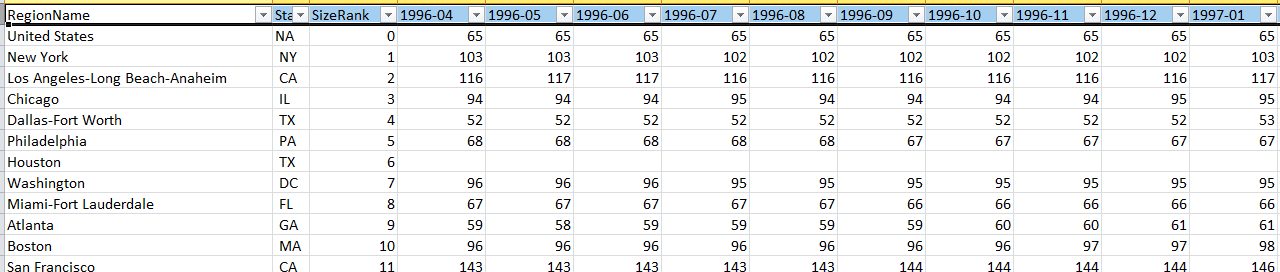

It can be noted that the rate of the housing per square foot didn't differ much over years but it varies a lot from area to area. Using this dataset we can predict sale prices in a better way since we know how much it costs in a particular city.

## Part 8 - Permutation Test

In [17]:
def fn_rmse(y_true, y_pred):
        e = np.sqrt(mean_squared_error(y_true, y_pred))
        rmse = round(e, 2)
        return rmse
    
def pScore(col):
    X = train[col]
    y = np.log(train['SalePrice'])
    n_classes = np.unique(y).size
    random = np.random.RandomState(seed=77)
    E = random.normal(size=(len(X), 2200))
    X = np.c_[X, E]
    reg = LinearRegression()
    k = KFold(2)
    score = make_scorer(fn_rmse, greater_is_better=False)
    score, permutation_scores, pvalue = permutation_test_score (reg, X, y, scoring=score, cv=k, n_permutations=100, n_jobs=1,verbose=0)
    plt.figure(figsize=(9,7))
    plt.hist(permutation_scores, 20, label='P SCORES', edgecolor='black')
    ylim = plt.ylim()
    plt.plot(2 * [score], ylim, '--g', linewidth=3, label=' (pvalue %s)' % pvalue)
    plt.plot(2 * [1. / n_classes], ylim, '--k', linewidth=3, label='Luck')
    plt.ylim(ylim)
    plt.legend()
    plt.xlabel('Score')
    plt.show();
    


In [18]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

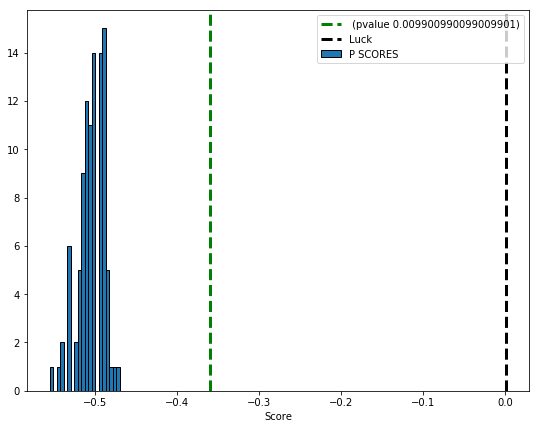

In [ ]:
list1=['OverallQual','GarageCars','GarageArea','MasVnrArea','GrLivArea','YearBuilt','KitchenAbvGr','BedroomAbvGr',
       'YrSold','FirePlaces']

for l in list1:
    pScore(l)

I considered 10 columns namely 'OverallQual','GarageCars','GarageArea','MasVnrArea','GrLivArea','YearBuilt','KitchenAbvGr','BedroomAbvGr',
 'YrSold','FirePlaces' to get the pscore for them. For this I used permutation_test_score, kfold, mean squared error and make_scorer

## Part 9 - Final Result

In [7]:
train1= pd.read_csv('train.csv')
test1=pd.read_csv('test.csv')
# train1= pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
# test1=pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')
#dropping columns which have null values
data_irr = train1.dropna(axis=1)
removecols = [col for col in train1.columns 
                                 if train1[col].isnull().any()]
ctrain1 = train1.drop(removecols, axis=1)
ctest1 = test1.drop(removecols, axis=1)
#label encoding for categorical variables
from sklearn import preprocessing
for col in ctrain1.columns:
    if ctrain1[col].dtypes=='object':
        lbl=preprocessing.LabelEncoder()
        lbl.fit(list(train1[col].values))
        ctrain1[col]=lbl.transform(list(ctrain1[col].values))
        
for col in ctest1.columns:
    if ctest1[col].dtypes=='object':
        lbl=preprocessing.LabelEncoder()
        lbl.fit(list(ctest1[col].values))
        ctest1[col]=lbl.transform(list(ctest1[col].values))
        

In [8]:
#replacing NAN in numerical columns by mode value
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numdf = ctrain1.select_dtypes(include=numerics)
for column in numdf.columns:
    ctrain1.fillna(ctrain1[column].mode()[0],inplace=True)

numdf1 = ctest1.select_dtypes(include=numerics)
for column in numdf1.columns:
    ctest1.fillna(ctest1[column].mode()[0],inplace=True)

In [9]:
#splitting the train dataset 
y=ctrain1[['SalePrice']]
X=ctrain1.drop(columns=['SalePrice'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=0)

In [10]:
#random forest regressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
reg = RandomForestRegressor(n_estimators = 100, random_state = 0)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
pred = reg.predict(ctest1)
out=pd.DataFrame(pred,ctest1.Id,['SalePrice'])
out.to_csv('outfin1.csv')

In [11]:
#xgb regressor
xg_reg = xgb.XGBRegressor(learning_rate=0.05,n_estimators=2000)
xg_reg.fit(X_train,y_train)
preds = xg_reg.predict(X_test)
predxg = xg_reg.predict(ctest1)
out=pd.DataFrame(predxg,ctest1.Id,['SalePrice'])
out.to_csv('xgb2.csv')

In [12]:
#lightgbm
import lightgbm as lgb
lgbmod = lgb.LGBMRegressor(objective='regression',num_leaves=10,learning_rate=0.05, n_estimators=750)
lgbmod.fit(X_train,y_train)
lgb_pred = lgbmod.predict(ctest1.values)
out=pd.DataFrame(lgb_pred,ctest1.Id,['SalePrice'])
out.to_csv('lightgbm2.csv')

In [13]:
#gradient boosting regressor
from sklearn import ensemble, tree, linear_model
gboost = ensemble.GradientBoostingRegressor(learning_rate=0.05, max_depth=3, 
                                               min_samples_leaf=20, min_samples_split=10, n_estimators=3500)
gboost.fit(X_train, y_train)
gboost_pred = gboost.predict(ctest1.values)
out=pd.DataFrame(gboost_pred,ctest1.Id,['SalePrice'])
out.to_csv('gboost2.csv')

Preprocessing of data:
Dropped columns with null values. Performed label encoding on all the categorical variables in test and training data. After that, replaced NANs with mode values in numerical columns.
Modelling:
For modelling of the data to predict sale price, I initially used RandomForest Regressor which gave a score of 0.14
On using XGBRegressor with learning rate of 0.05 the score improved to 0.13. The best score 0.12 was obtained using Light GBM model with n_estimators=750 and learning rate=0.05. GradientBoosting Regressor also gave around 0.13 as the score. 

Kaggle Link: https://www.kaggle.com/aishwaryavhs07

Highest Rank: 1696

Score: 0.12797

Number of entries: 12

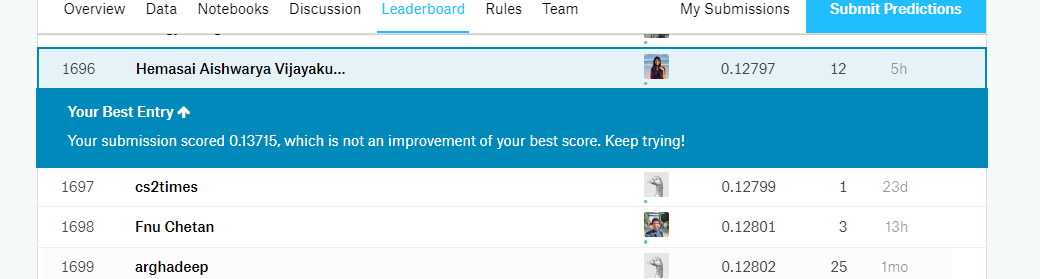

References: <br>
https://data.world/gmoney/metro-median-price-per-sqft/workspace/project-summary?agentid=gmoney&datasetid=metro-median-price-per-sqft <br>
https://www.kaggle.com/dansbecker/xgboost <br>
https://www.kaggle.com/aussie84/eda-let-s-cluster-the-houses <br>
https://scikit-learn.org/stable/auto_examples/feature_selection/plot_permutation_test_for_classification.html#sphx-glr-auto-examples-feature-selection-plot-permutation-test-for-classification-py <br>
https://towardsdatascience.com/machine-learning-algorithms-part-9-k-means-example-in-python-f2ad05ed5203

